### Dataset:
* news.csv

### This project contains 4 sub projects:
1. Topic modeling
2. Key-phrases/ Key-words extraction and ranking
3. Emerging sub-topics identification
4. Sentiment Analysis

### Imports

In [2]:
import os
import re
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import pickle 
import pyLDAvis

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from pyLDAvis import sklearn as sklearn_lda
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# 1. Topic modeling using LDA

###### Main steps:
1. Load data
2. Data cleaning
3. Exploratory analysis
4. Prepare data for LDA analysis
5. LDA model training
6. Analyze LDA model results

(reference: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
<br>LDA tutorial: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158 
<br>Youtube: https://www.youtube.com/watch?v=3mHy4OSyRf0)

### Load data
Select the fist 5000 lines as the dataset used in this project. 

In [3]:
#os.chdir('..')

# Read data
news = pd.read_csv('news.csv', nrows=5000)

# Print head
news.head()

,index,id,title,author,date,content,year,month,publication,category,digital,section,url
0,0,1,Agent Cooper in Twin Peaks is the audience: on...,\nTasha Robinson\n,2017-05-31,And never more so than in Showtime’s new...,2017,5,Verge,Longform,1.0,NaN,NaN
1,1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017,5,Verge,Longform,1.0,NaN,NaN
2,2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,Super Deluxe built a weird internet empi...,2017,5,Verge,Longform,1.0,NaN,NaN
3,3,4,How Anker is beating Apple and Samsung at thei...,\nNick Statt\n,2017-05-22,Steven Yang quit his job at Google in th...,2017,5,Verge,Longform,1.0,NaN,NaN
4,4,5,Tour Black Panther’s reimagined homeland with ...,\nKwame Opam\n,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017,5,Verge,Longform,1.0,NaN,NaN


### Prepare a word cloud function to help us visualize the text in next steps

(reference: https://www.datacamp.com/community/tutorials/wordcloud-python)

In [4]:
def draw_wordcloud(content_to_plot):
    long_string = ','.join(list(content_to_plot.values))
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    return wordcloud

### Data Cleaning 
##### Drop Redundant Columns
In this project, I am going to use the column "content" to find the topics

In [5]:
# Remove the columns that we don't need in Topic modeling
news_4_topic_modeling = news.drop(columns=['index', 'id', 'author', 'date', 'year', 'month', 'publication', 'category', 'digital', 'section', 'url'], axis=1)

# Print out the first 5 rows of news
news_4_topic_modeling.head()

,title,content
0,Agent Cooper in Twin Peaks is the audience: on...,And never more so than in Showtime’s new...
1,"AI, the humanity!",AlphaGo’s victory isn’t a defeat for hum...
2,The Viral Machine,Super Deluxe built a weird internet empi...
3,How Anker is beating Apple and Samsung at thei...,Steven Yang quit his job at Google in th...
4,Tour Black Panther’s reimagined homeland with ...,Ahead of Black Panther’s 2018 theatrical...


##### 2. Remove punctuation / lower casing / apostrophe

In [6]:
def preprocess(table, column, column_processed):
    # Remove punctuation
    table[column_processed] = table[column].map(lambda x: re.sub('[,\\.!?]', '', str(x)))

    # Convert the content to lowercase
    table[column_processed] = table[column_processed].map(lambda x: x.lower())

    # Remove apostrophe
    table[column_processed] = table[column_processed].map(lambda x: np.char.replace(x, "'", ""))
    
    return table

news_4_topic_modeling = preprocess(news_4_topic_modeling, 'content', 'content_processed')

##### 3. Remove repetitive sentences (will be included in the future work)

#### Now let's see how does the word cloud looks like

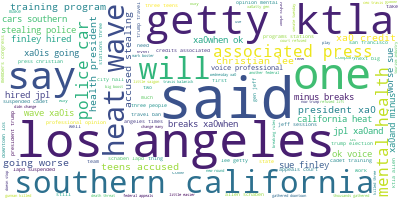

In [7]:
wordcloud = draw_wordcloud(news_4_topic_modeling['content_processed'])
wordcloud.to_image()

##### 3. Reduce unique words by stemming
(There are 2 stemmer algorithems: PorterStammer or LancasterStammer, here we choose LancasterStammer because it will convert the words to its root word

reference: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

In [8]:
# Only need to run it once when installing nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/yixunli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def stemSentence(sentence):
    wordnet_lemmatizer = WordNetLemmatizer()
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

news_4_topic_modeling['content_processed'] = news_4_topic_modeling['content_processed'].map(lambda x: stemSentence(x))

#### Now let's see how does the word cloud looks like after stemming

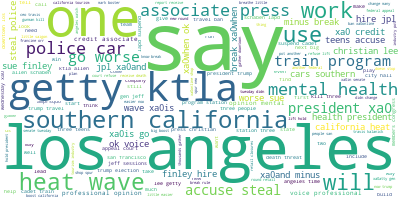

In [10]:
wordcloud = draw_wordcloud(news_4_topic_modeling['content_processed'])
wordcloud.to_image()

###### Note: need to add this in future work to remove the xa0:  text = " ".join(text.replace(u"\xa0", " ").strip().split())

### Prepare text for LDA analysis using CountVectorizer

(reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

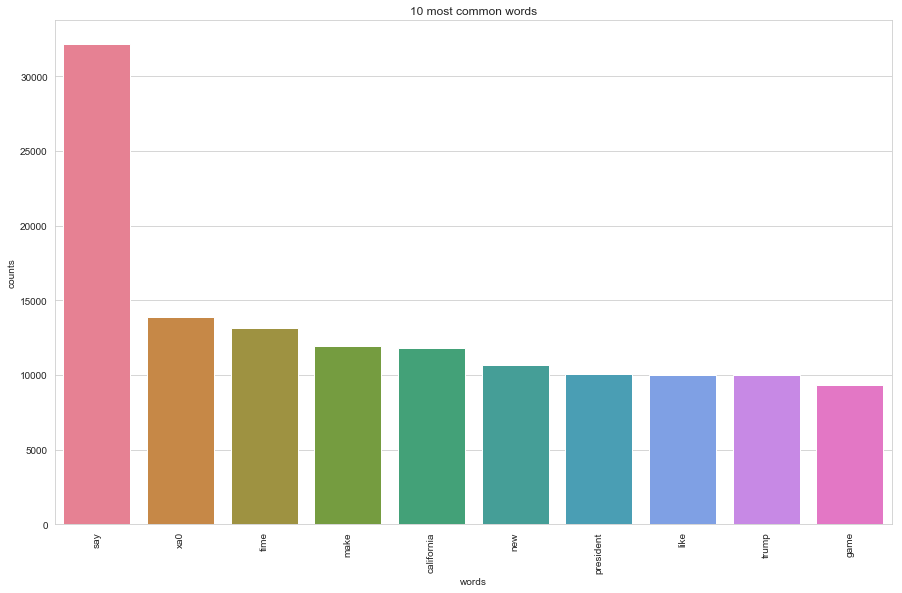

In [11]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    
    # Show unique words
    words = count_vectorizer.get_feature_names() 
    
    # Calculate frequency of each unique word
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    # Make words-total_counts a dict, sort it according to the total_counts
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed article content, count_data is the term-document matrix
count_data = count_vectorizer.fit_transform(news_4_topic_modeling['content_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model training
(reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

In [12]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_): # topic word distribution
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

def train_lda_and_print(number_topics, number_words, count_data, count_vectorizer):
    # Create and fit the LDA model
    lda = LDA(n_components=number_topics, random_state=8)
    lda_output = lda.fit(count_data)

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    print_topics(lda, count_vectorizer, number_words)
    
    return lda
    
lda = train_lda_and_print(number_topics, number_words, count_data, count_vectorizer)

Topics found via LDA:

Topic #0:
california xa0 xa0is president say break credit getty ktla police

Topic #1:
xa0 point team time make win say game second leave

Topic #2:
say game make team play like time just season think

Topic #3:
say trump state president house make year people california new

Topic #4:
say like company new time make work people fan years


### Show Document-topic distribution

In [13]:
def show_doc_topic_distribution(matrix, count_data, lda):
    lda_output = lda.transform(count_data)
    topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
    docnames = ['Doc' + str(i) for i in range(len(matrix['content_processed']))]
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    df_document_topic['content'] = news_4_topic_modeling['content']

    cols = df_document_topic.columns.tolist()
    cols.insert(0, cols.pop(cols.index('content')))

    df_document_topic = df_document_topic.reindex(columns= cols)
    return df_document_topic

df_document_topic = show_doc_topic_distribution(news_4_topic_modeling, count_data, lda)
df_document_topic.head()

,content,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,And never more so than in Showtime’s new...,0.0,0.00,0.05,0.01,0.94,4
1,AlphaGo’s victory isn’t a defeat for hum...,0.0,0.00,0.64,0.01,0.35,2
2,Super Deluxe built a weird internet empi...,0.0,0.00,0.28,0.00,0.72,4
3,Steven Yang quit his job at Google in th...,0.0,0.02,0.00,0.00,0.98,4
4,Ahead of Black Panther’s 2018 theatrical...,0.0,0.00,0.00,0.00,0.99,4


### Add topic column to our dataset for future usage in next projects

In [14]:
news_4_topic_modeling['topic'] = ""
doc_topic = lda.transform(count_data)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    news_4_topic_modeling['topic'][n] = topic_most_pr

In [15]:
news_4_topic_modeling.head()

,title,content,content_processed,topic
0,Agent Cooper in Twin Peaks is the audience: on...,And never more so than in Showtime’s new...,and never more so than in showtime ’ s new ser...,4
1,"AI, the humanity!",AlphaGo’s victory isn’t a defeat for hum...,alphago ’ s victory isn ’ t a defeat for human...,2
2,The Viral Machine,Super Deluxe built a weird internet empi...,super deluxe build a weird internet empire can...,4
3,How Anker is beating Apple and Samsung at thei...,Steven Yang quit his job at Google in th...,steven yang quit his job at google in the summ...,4
4,Tour Black Panther’s reimagined homeland with ...,Ahead of Black Panther’s 2018 theatrical...,ahead of black panther ’ s 2018 theatrical rel...,4


### Analyze our LDA model
install pyLDAvis: conda install -c conda-forge pyldavis

In [16]:
LDAvis_data_filepath = os.path.join(os.path.expanduser('~')
                                    + '/Documents/projects/ldavis_prepared_'
                                    + str(number_topics))

if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath + '.html')

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Visualize the results
1. Open the ldavis_prepared_5.html
2. The red bars represent the frequency of a term in a given topic, and the blue bars represent a term's frequency across the entire corpus
3. Change the value of λ to adjust the term rankings -- small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic

(reference: http://www.kennyshirley.com/LDAvis/)

### Future work:
1. Remove repetitive sentences in data clearning
2. Use GridSearch to determine the best LDA model (reference: https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6)
3. Use title instead of content to fit the model and see how the topics are clustered
4. Combine information from titles + contents and see how the topics are clustered
5. Evaluate and compare the above 2 methods with the methods we did in this experiment

# 2. Key-phrases extraction and ranking using TF-IDF

###### Main steps:
1. Reload the data from task #1
2. Data cleaning
3. Preparing data for TF-IDF analysis
4. TF-IDF model training
5. Analyze TF-IDF scores and ranking in the documents of each topic and define key-phrases

(reference: https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)

### Data Cleaning 
##### 1. Drop Redundant Columns (We will need content_processed and topic in this project)

In [17]:
news_4_key_extra = news_4_topic_modeling.drop(columns=['title', 'content'], axis=1)
news_4_key_extra.head()

,content_processed,topic
0,and never more so than in showtime ’ s new ser...,4
1,alphago ’ s victory isn ’ t a defeat for human...,2
2,super deluxe build a weird internet empire can...,4
3,steven yang quit his job at google in the summ...,4
4,ahead of black panther ’ s 2018 theatrical rel...,4


##### 2. Aggregate content_processed by the topics

In [18]:
news_4_key_extra = news_4_key_extra.groupby('topic')['content_processed'].apply(lambda x: "{%s}" % '.\n '.join(x))

### TF-IDF model training

In [19]:
corpus = list(news_4_key_extra)
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
X = vectorizer.fit_transform(corpus)
words = vectorizer.get_feature_names() 

### Analyze the results
(reference: https://buhrmann.github.io/tfidf-analysis.html)

In [20]:
def top_tfidf_feats(row, words, top_n):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(words[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['words', 'tfidf']
    return df

def top_mean_feats(X, words, top_n):
    D = X.toarray()
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, words, top_n)

### Now let's check the IF-IDF words-scores in the documents in each topic
The higher the IF-IDF score is, the more meaningful the word is in the document.

##### 1. IF-IDF words-values in topic 0 

In [21]:
top_mean_feats(X[0], words, top_n=10)

,words,tfidf
0,california,0.128593
1,say,0.112211
2,getty ktla,0.105842
3,xa0,0.103705
4,xa0is,0.101093
5,president,0.094703
6,getty,0.089053
7,trump,0.083264
8,break,0.079594
9,credit,0.076740


##### 2. IF-IDF words-values in topic 1

In [22]:
top_mean_feats(X[1], words, top_n=10)

,words,tfidf
0,say,0.185926
1,game,0.174120
2,team,0.172575
3,point,0.171957
4,xa0,0.171462
5,make,0.165590
6,time,0.153475
7,win,0.123003
8,play,0.108725
9,second,0.104151


##### 3. IF-IDF words-values in topic 2

In [23]:
top_mean_feats(X[2], words, top_n=10)

,words,tfidf
0,say,0.413178
1,game,0.327922
2,team,0.187922
3,make,0.182807
4,play,0.174999
5,time,0.159294
6,season,0.154538
7,just,0.126897
8,like,0.126807
9,lakers,0.110137


##### 4. IF-IDF words-values in topic 3

In [24]:
top_mean_feats(X[3], words, top_n=10)

,words,tfidf
0,say,0.465572
1,trump,0.190908
2,president,0.150275
3,house,0.132843
4,state,0.132056
5,make,0.107087
6,california,0.098043
7,year,0.096994
8,new,0.095814
9,people,0.094110


##### 5. IF-IDF words-values in topic 4

In [25]:
top_mean_feats(X[4], words, top_n=10)

,words,tfidf
0,say,0.288424
1,like,0.147628
2,make,0.138435
3,new,0.137669
4,time,0.134094
5,company,0.113218
6,work,0.102270
7,people,0.100897
8,just,0.094258
9,amprsquos,0.091593


### Future work

1. Use title instead of content to fit the model
2. Combine information from titles + contents to fit the model
3. Research and try other Key-phrase extract algorithms

# 3. Build topics distribution in time using LDA

###### Main steps:
1. Reload the prepared data from task #1
3. Data cleaning
3. Prepare data for LDA analysis 
4. LDA model training
5. Plot and Analyze LDA model results on time series

reference: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

### Data preparing
In this project, I am going to use the column "content_processed" to find the topics
##### 1. Drop Redundant Columns (We will need content_processed and year and month in this project)

In [26]:
news_4_sub_topics = news_4_topic_modeling
news_4_sub_topics = news_4_sub_topics.drop(columns=['content', 'topic'], axis=1)
news_4_sub_topics['year'] = news['year']
news_4_sub_topics['month'] = news['month']
news_4_sub_topics.head()

,title,content_processed,year,month
0,Agent Cooper in Twin Peaks is the audience: on...,and never more so than in showtime ’ s new ser...,2017,5
1,"AI, the humanity!",alphago ’ s victory isn ’ t a defeat for human...,2017,5
2,The Viral Machine,super deluxe build a weird internet empire can...,2017,5
3,How Anker is beating Apple and Samsung at thei...,steven yang quit his job at google in the summ...,2017,5
4,Tour Black Panther’s reimagined homeland with ...,ahead of black panther ’ s 2018 theatrical rel...,2017,5


##### 2. Aggregate year and month column

In [27]:
news_4_sub_topics['year-month'] = news_4_sub_topics['year'].map(str) +'-'+ news_4_sub_topics['month'].map(str)
news_4_sub_topics.head()

,title,content_processed,year,month,year-month
0,Agent Cooper in Twin Peaks is the audience: on...,and never more so than in showtime ’ s new ser...,2017,5,2017-5
1,"AI, the humanity!",alphago ’ s victory isn ’ t a defeat for human...,2017,5,2017-5
2,The Viral Machine,super deluxe build a weird internet empire can...,2017,5,2017-5
3,How Anker is beating Apple and Samsung at thei...,steven yang quit his job at google in the summ...,2017,5,2017-5
4,Tour Black Panther’s reimagined homeland with ...,ahead of black panther ’ s 2018 theatrical rel...,2017,5,2017-5


##### 3. Aggregate content_processed by each month

In [28]:
news_4_sub_topics = news_4_sub_topics.groupby('year-month')['content_processed'].apply(lambda x: "{%s}" % '.\n '.join(x))
news_4_sub_topics = news_4_sub_topics.reset_index()
news_4_sub_topics.head()

,year-month,content_processed
0,2012-12,{nokia be build its own windows rt tablet that...
1,2012-3,{a former technology manager for the los angel...
2,2013-1,{microsoft didnt have a booth or even an offic...
3,2013-10,{to an unsuspecting eye the torres family home...
4,2013-11,{its 90 minutes to game time in foxboro massac...


##### 4. Reduce unique words by stemming

In [29]:
news_4_sub_topics['content_processed'] = news_4_sub_topics['content_processed'].map(lambda x: stemSentence(x))

### Prepare text for LDA analysis & LDA model training

In [30]:
number_topics = 5
number_words = 5

count_data1 = count_vectorizer.fit_transform(news_4_sub_topics['content_processed'])

lda1 = train_lda_and_print(number_topics, number_words, count_data1, count_vectorizer)

Topics found via LDA:

Topic #0:
xa0 say california trump president

Topic #1:
say make time game new

Topic #2:
say like make company new

Topic #3:
point lakers state say game

Topic #4:
say california trump time president


### Show Document-topic distribution in each month

In [76]:
df_document_topic1 = show_doc_topic_distribution(news_4_sub_topics, count_data1, lda1)
df_document_topic1['year-month'] = pd.to_datetime(news_4_sub_topics['year-month'])
df_document_topic1 = df_document_topic1.sort_values(by=['year-month'])
df_document_topic1.head()

,content,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,year-month
1,AlphaGo’s victory isn’t a defeat for hum...,0.36,0.64,0.00,0.0,0.00,1,2012-03-01
0,And never more so than in Showtime’s new...,0.00,0.00,0.98,0.0,0.01,2,2012-12-01
2,Super Deluxe built a weird internet empi...,0.00,0.00,1.00,0.0,0.00,2,2013-01-01
6,How a weapon against war became a weapon...,0.00,0.00,1.00,0.0,0.00,2,2013-02-01
7,Inside the big business of imagining the...,0.00,0.00,1.00,0.0,0.00,2,2013-03-01


### Plot topics distribution in time

Text(0, 0.5, 'Score')

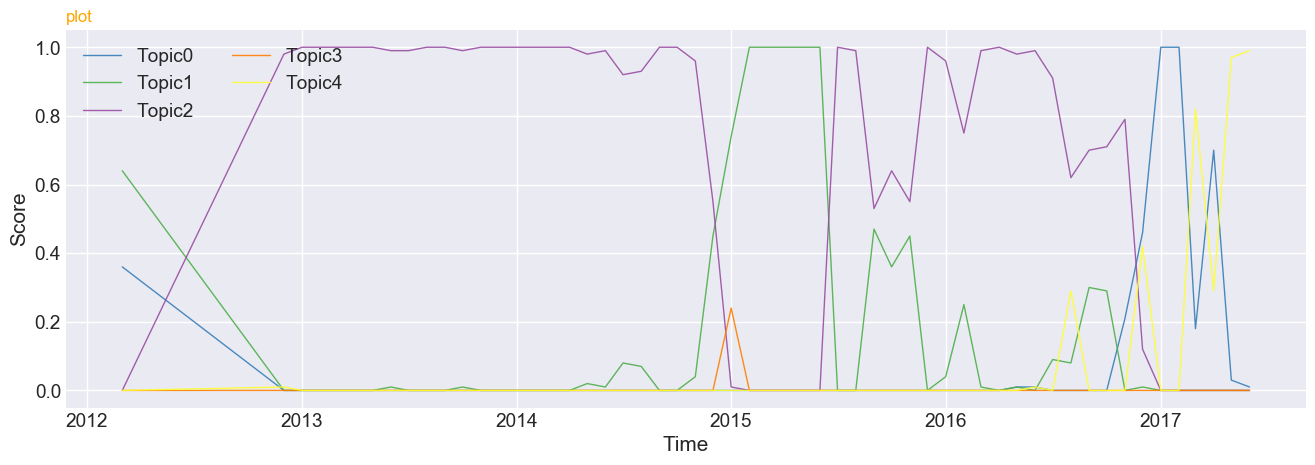

In [79]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(16,5), dpi=100)

num=0
for column in df_document_topic1.drop(columns=['dominant_topic', 'content', 'year-month'], axis=1):
    num += 1
    plt.plot(df_document_topic1['year-month'], df_document_topic1[column], color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend(loc=2, ncol=2)

plt.title('plot', loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel('Time')
plt.ylabel('Score')

### Analyze the plot
From the plot we can see:
1. Topic 0 only happens with a low document-topic distribution score between 2012 to 2013, then during 2017 it becomes a popular topic again, it might be a popular topic in the future
2. Topic 1 is very popular at the beginning of 2015, then it becomes less popular as time goes by till the beginning of 2017, then we don't see it after mid-2017. It might not be a popular topic after 2017
3. Topic 2 is always popular from 2012 to 2015, then from mid 2015 to 2017. Although the document-topic distributio score is low during 2017, we can still predict that it will be popular in the future
4. Topic 3 is not popular from 2012 to 2017, we can predict that it will not be popular in the future
5. Topic 4 is not popular from 2012 to mid 2016, but after mid 2016 the score is increasing. We can predict that it will be popular in the fure

# 4. Sentiment Analysis using VADER

VADER belongs to a type of sentiment analysis that is based on lexicons of sentiment-related words. To work out whether these words are positive or negative (and optionally, to what degree), the developers of these approaches need to get a bunch of people to manually rate them, which is obviously pretty expensive and time-consuming. Incidentally, the developers of VADER used Amazon’s Mechanical Turk to get most of their ratings, which is a very quick and cheap way to get their ratings.
<br>reference: http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

## 4.1 identify topic sentiment for each article

###### Main steps:
1. Reload the prepared data from task #1
3. Data cleaning
3. Prepare data for VADER analysis 
4. VADER model training
5. Plot and Analyze sentiment scores output by VADER for each article in each topic


### Data Cleaning 
##### 1. Drop Redundant Columns (We will need content_processed and date in this work)

In [33]:
news_4_sentiment = news_4_topic_modeling.drop(columns=['title', 'content'], axis=1)
news_4_sentiment['date'] = news['date']
news_4_sentiment['id'] = news['id']
news_4_sentiment.head()

,content_processed,topic,date,id
0,and never more so than in showtime ’ s new ser...,4,2017-05-31,1
1,alphago ’ s victory isn ’ t a defeat for human...,2,2017-05-30,2
2,super deluxe build a weird internet empire can...,4,2017-05-25,3
3,steven yang quit his job at google in the summ...,4,2017-05-22,4
4,ahead of black panther ’ s 2018 theatrical rel...,4,2017-05-15,5


##### 2. Sort the rows by topic

In [34]:
news_4_sentiment_sorted = news_4_sentiment.sort_values(by=['topic'])
news_4_sentiment_sorted.head()

,content_processed,topic,date,id
1860,the move end what the state\s governor call a ...,0,2017-02-02,8513
1636,a multi-vehicle crash on the northbound 405 ne...,0,2017-01-21,8263
1634,to the editor : george skelton make some good ...,0,2017-01-21,8261
1633,`` \n\nthousands flood downtown los angeles fo...,0,2017-01-22,8260
1632,before the brash unpredictable donald trump th...,0,2017-01-21,8259


### VADER model trainning

In [37]:
def add_sentiment_scores(analyser, matrix, row, doc):
    sentiment = analyser.polarity_scores(doc)
    matrix['negative'][row] = sentiment['neg']
    matrix['neutral'][row] = sentiment['neu']
    matrix['positive'][row] = sentiment['pos']
    matrix['compound'][row] = sentiment['compound']

def vader_train(matrix):
    analyser = SentimentIntensityAnalyzer()
    news_4_sentiment_sorted['negative'] = ""
    news_4_sentiment_sorted['neutral'] = ""
    news_4_sentiment_sorted['positive'] = ""
    news_4_sentiment_sorted['compound'] = ""
    for row in range(len(matrix)):
        add_sentiment_scores(analyser, matrix, row, matrix['content_processed'][row])
        
vader_train(news_4_sentiment_sorted)

### Now let's check the sentiment scores for each article in each topic

In [38]:
news_4_sentiment_sorted.drop(columns=['date']).head()

,content_processed,topic,id,negative,neutral,positive,compound
1860,the move end what the state\s governor call a ...,0,8513,0.185,0.746,0.069,-0.9996
1636,a multi-vehicle crash on the northbound 405 ne...,0,8263,0.144,0.789,0.067,-0.9967
1634,to the editor : george skelton make some good ...,0,8261,0.154,0.762,0.084,-0.9978
1633,`` \n\nthousands flood downtown los angeles fo...,0,8260,0.111,0.799,0.09,-0.9945
1632,before the brash unpredictable donald trump th...,0,8259,0.128,0.732,0.14,0.929


### What does the values mean? What is compound?
* neg: Negative
* neu: Neutral
* pos: Positive
* compound: Compound (i.e. aggregated score)
<pre><code>compound = normalize(sum_s)
def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score/math.sqrt((score*score) + alpha)
    return norm_score<code><pre>
    
Is Compound calculated from the [pos, neu, neg]? -- No
* the compound score is a normalized score of sum_s and
* sum_s is the sum of valence computed based on some heuristics and a sentiment lexicon (aka. Sentiment Intensity) and
* the normalized score is simply the sum_s divided by its square plus an alpha parameter that increases the denominator of the normalization function.

reference: https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

### Scatter plot for the sentiment scores for each article in each topic

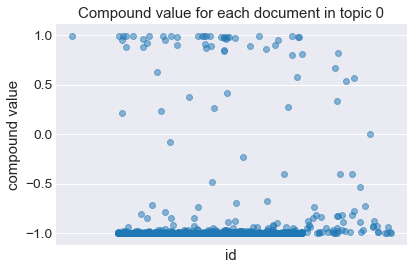

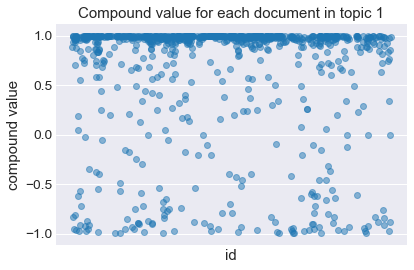

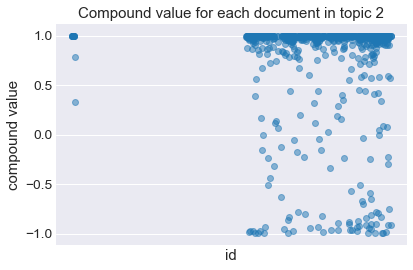

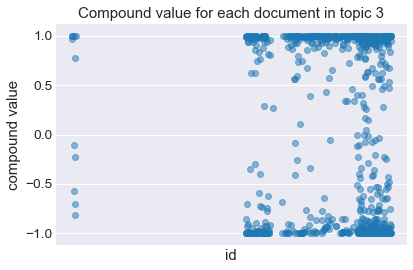

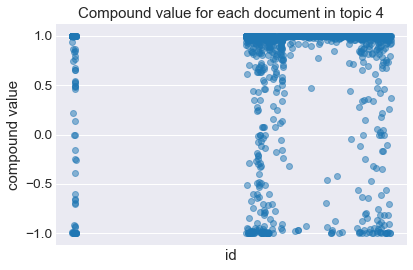

In [39]:
def plot_compound(by_which_column, index, topic):
    fig, ax = plt.subplots()
    ax.scatter(topic[by_which_column], topic['compound'], alpha=0.5)
    ax.set_xlabel(by_which_column, fontsize=15)
    ax.set_ylabel('compound value', fontsize=15)
    ax.set_title('Compound value for each document in topic ' + str(index))
    ax.grid(True)
    plt.xticks([])
    fig.tight_layout()
    plt.show()
    
for index in range(number_topics):    
    plot_compound('id', index, news_4_sentiment_sorted.loc[news_4_sentiment_sorted['topic'] == index])

## 4.2 The overall daily sentiment for each topic

###### Main steps:
1. Reload the prepared data from task #4.1
2. Prepare data for VADER analysis 
3. VADER model training
4. Plot and Analyze the overall daily sentiment scores output by VADER for each topic

### Still use the dataset news_4_sentiment_sorted

In [40]:
news_4_stm_daily = news_4_sentiment_sorted.sort_values(by=['date'])

In [41]:
news_4_stm_daily.head()

,content_processed,topic,date,id,negative,neutral,positive,compound
2828,a former technology manager for the los angele...,3,2012-03-30,9531,0.085,0.855,0.06,-0.8975
1204,nokia be build its own windows rt tablet that ...,4,2012-12-24,7798,0.008,0.943,0.048,0.8074
1203,nokia be plan a new line of lumia windows phon...,4,2013-01-03,7797,0,0.957,0.043,0.765
1199,teenage engineer have build a reputation for u...,4,2013-01-07,7793,0.026,0.837,0.137,0.9992
1201,vizios 10-inch android tablet might be one of ...,2,2013-01-07,7795,0.035,0.868,0.096,0.9798


### Scatter plot for the overall daily sentiment for each topic

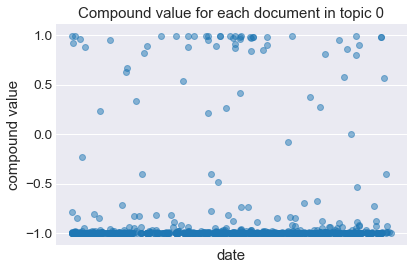

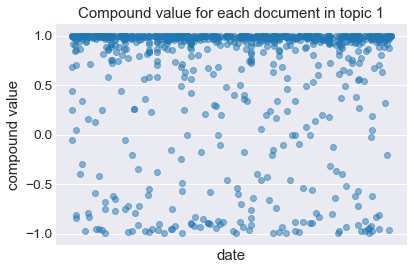

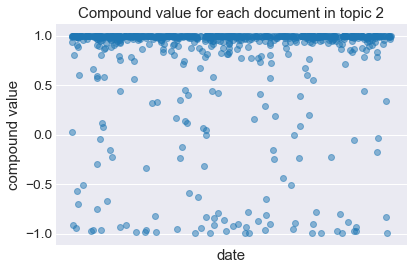

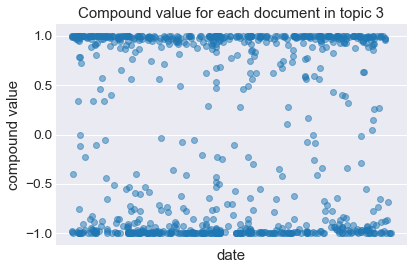

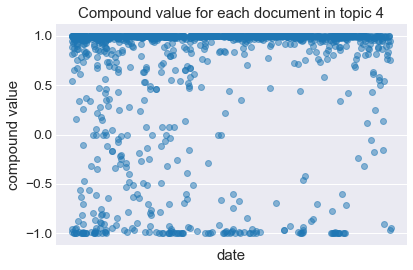

In [42]:
for index in range(number_topics):    
    plot_compound('date', index, news_4_sentiment_sorted.loc[news_4_sentiment_sorted['topic'] == index])

### Future work
1. In this work we use Vader to get the sentiment scores, in the future we should try different algorithm to calculate the sentiment scores
2. We can also apply semi-supervised learning on this project since there is no lable in the dataset at the beginning. What we can do is first cluster the documents, then manually add the sentiment lables to some of the documents, then try to predict lables for rest of the documents in the same cluster